# QPSK Transmitter & Receiver Simulation

This notebook demonstrates a complete QPSK digital communication chain implemented for prototyping and evaluation. It is intended to be run interactively in Jupyter and to serve as a reference for porting algorithms to the C++ sdrlib.

## What this notebook covers
- Bit generation and Gray-coded QPSK mapping (with optional differential coding)
- Pulse shaping (RRC), upsampling and matched filtering
- Channel impairments: CFO (carrier frequency offset), STO (fractional sample timing offset), and AWGN
- Symbol timing recovery (Gardner TED with Farrow cubic interpolation)
- Carrier recovery (Costas loop)
- Demodulation and BER calculation
- Visualizations: time-domain, spectrum, and constellation plots at key stages

### Block Diagram    

![QPSK Pipeline Block Diagram](../images/qpsk_pipeline_block_diagram/QPSK_pipeline_block_diagram.png)


## Quick instructions
1. Install dependencies (see repository top-level README).  
2. Open this notebook in Jupyter and run cells top-to-bottom.  

## Key parameters you can tweak
- N_BITS: number of random bits to simulate
- SNR_DB: channel SNR (dB)
- CFO / STO: fractional frequency/timing offsets to stress recovery blocks

## Expected outputs
- Time-domain and spectral views of transmitted and received signals
- Constellation diagrams before/after synchronization
- Final BER printed to the notebook



Author: Cole Delong

### Imports and Constants

In [38]:
# Reload imports every time this cell is run
%reload_ext autoreload
%autoreload 2

# Imports
import numpy as np
import matplotlib.pyplot as plt

# Custom Utils
import py_sdrlib as cu                      # C++ utils

import py_utils as pu                       # Python utils
from py_utils import visualization as vz    # Python visualization utils

# Constants
SPS = int(2)                        # samples per symbol. Must be 2 for Gardner TED
N_BITS = 10**5                      # number of bits to simulate
N_SYMBOLS = int(N_BITS/2)           # qpsk: 2 bits/sample, IF differential coding: +1 symbol
N_RRC_TAPS = SPS*10 + 1             # number of taps in rrc filter (10 on each side of center)
SNR_DB = 20                         # channel SNR in dB  


### Bit generation

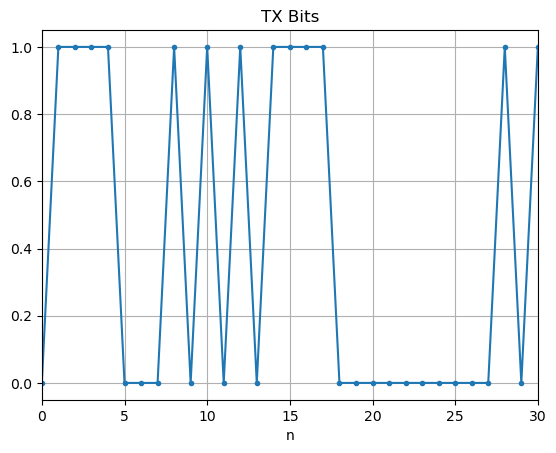

In [39]:
# Random bits
bits_tx = np.random.randint(2, size=N_BITS)
vz.plot_signal(bits_tx, title='TX Bits', xlim=[0, 30]);

### Differential QPSK Modulation

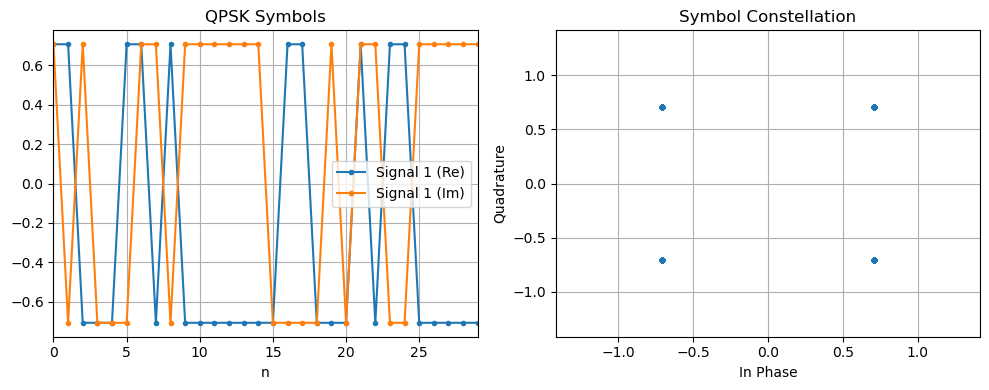

In [40]:
# Use differential coding to account for phase ambiguity
sym_tx = pu.modulation.modulate_qpsk(bits_tx)
sym_tx = pu.coding.diff_encode_psk_symbols(sym_tx)

fig, ax = vz.visualize(
    sym_tx, 
    plots=('time', 'constellation'), 
    plot_kwargs={
        'time': {'title': 'QPSK Symbols', 'n_samps': 30}, 
        'constellation': {'title': 'Symbol Constellation'}
    }
);

### RRC Pulse Filtering

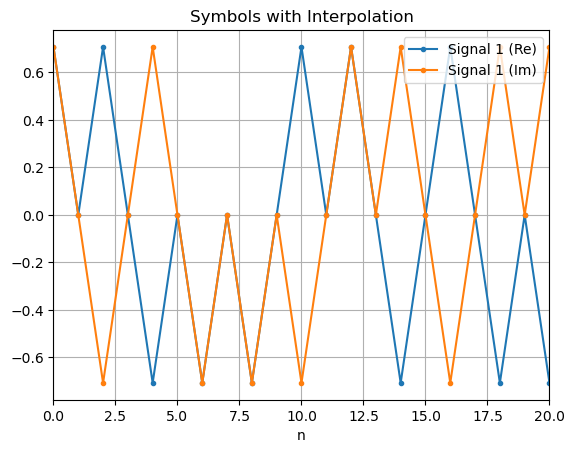

In [41]:
# Upsample by factor of SPS
sym_upsamp = pu.dsp.upsample(sym_tx, SPS)

vz.plot_signal(sym_upsamp, title='Symbols with Interpolation', xlim=[0, 10*SPS]);

### Root Raised Cosine Filter Visualization

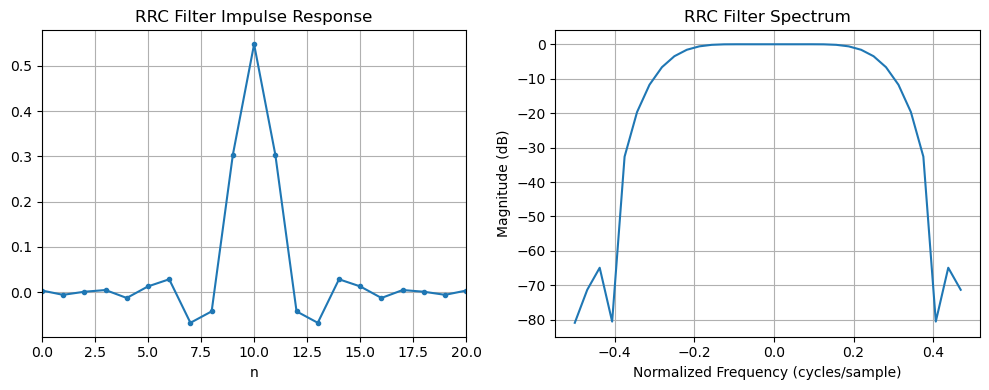

In [42]:
h_rrc = pu.dsp.rrc(Ts=SPS, n_taps=N_RRC_TAPS)

fig, ax = vz.visualize(
    h_rrc.real, 
    plots=('time', 'frequency'), 
    plot_kwargs={
        'time': {'title': 'RRC Filter Impulse Response'}, 
        'frequency': {'title': 'RRC Filter Spectrum'}
    }
);


### Pulse Filtering

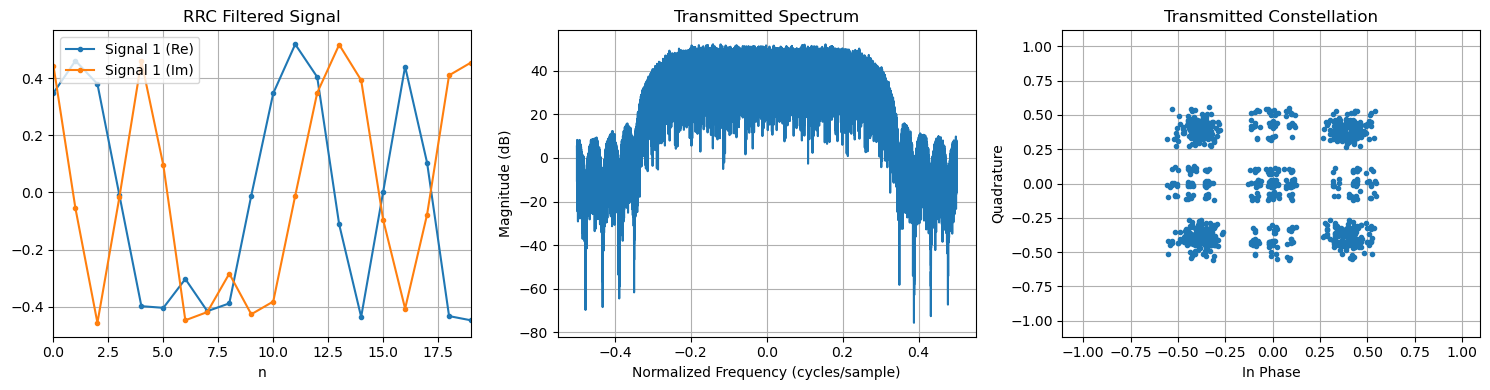

In [43]:
# Convolve signal with RRC filter
sig_tx = pu.rrc_filter(sym_upsamp, n_taps=N_RRC_TAPS, Ts=SPS).astype(np.complex64)

fig, ax = vz.visualize(
    sig_tx, 
    plots=('time', 'frequency', 'constellation'), 
    plot_kwargs={
        'time': {'title': 'RRC Filtered Signal', 'n_samps': 20}, 
        'frequency': {'title': 'Transmitted Spectrum'},
        'constellation': {'title': 'Transmitted Constellation'}
    }
);

### Channel Impairments

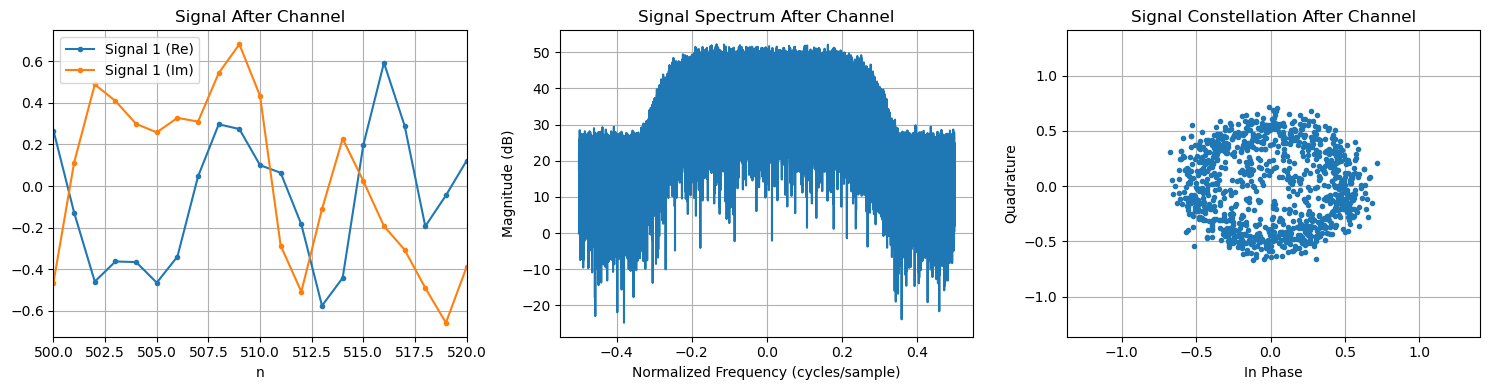

In [44]:
# Apply CFO
# testing/realistic: 1-5%, aggressive: 10%
sig_chan = np.empty_like(sig_tx).astype(np.complex64)

# sig_chan = pu.channel.apply_cfo(sig_tx, 0.05)
cu.channel.apply_cfo(sig_tx, sig_chan, 0.05)

# Apply STO
mu = 0.3
sig_chan = pu.channel.apply_sto(sig_chan, mu)

# AWGN
sig_chan = pu.channel.apply_awgn(sig_chan, SNR_DB)
sig_rx = sig_chan

fig, ax = vz.visualize(
    sig_rx, 
    plots=('time', 'frequency', 'constellation'), 
    plot_kwargs={
        'time': {'title': 'Signal After Channel', 'xlim': [500, 520]}, 
        'frequency': {'title': 'Signal Spectrum After Channel'},
        'constellation': {'title': 'Signal Constellation After Channel'}
    }
);

### Matched Filtering

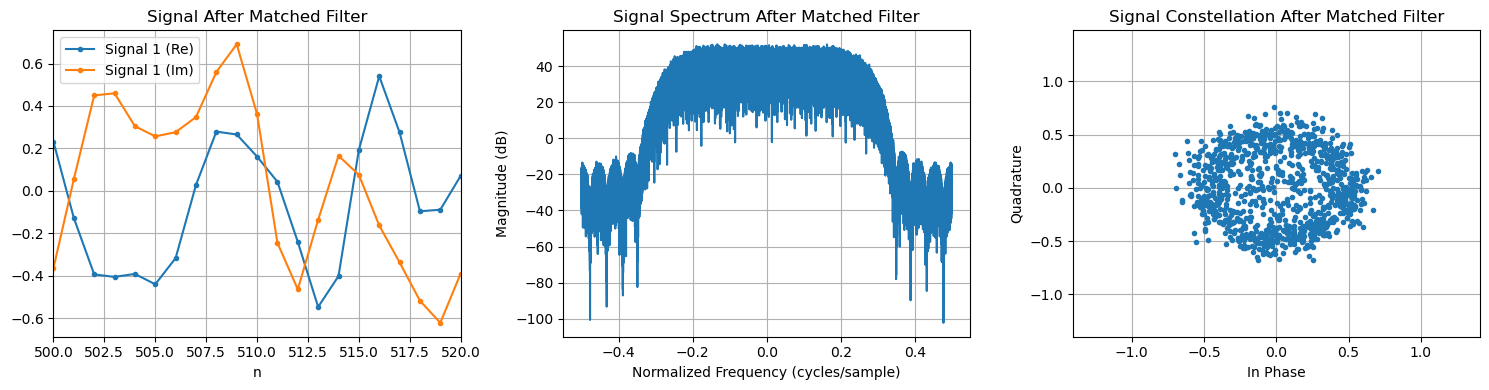

In [45]:
### Matched filter ###
# sig_matched = np.convolve(sig_rx, h_rrc)
sig_matched = pu.dsp.rrc_filter(sig_rx, n_taps=N_RRC_TAPS, Ts=SPS)

fig, ax = vz.visualize(
    sig_matched, 
    plots=('time', 'frequency', 'constellation'), 
    plot_kwargs={
        'time': {'title': 'Signal After Matched Filter', 'xlim': [500, 520]}, 
        'frequency': {'title': 'Signal Spectrum After Matched Filter'},
        'constellation': {'title': 'Signal Constellation After Matched Filter'}
    }
);

### Symbol Timing Recovery

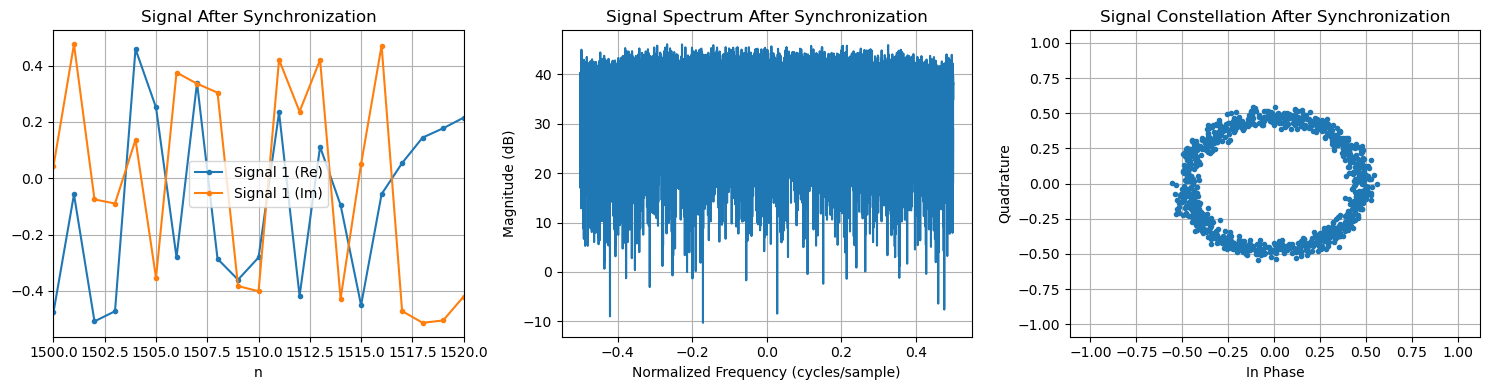

In [46]:
"""
Gardner: 
- Low complexity
- 2x oversampling fine since sample rate is same for both rx and tx on PlutoSDR
- Better than M&M in lower SNR environments
- Real-time low-latency

cubic interpolation:
- Complexity not bad (better than sinc) when using Farrow structures
- More accurate than lower order quadratic interpolaters
"""
stc = pu.timing_recovery.GardnerSymbolTimingCorrector()
symbols_sampled = stc.correct_batch(sig_matched)
# symbols_sampled = sig_matched[::SPS]

fig, ax = vz.visualize(
    symbols_sampled, 
    plots=('time', 'frequency', 'constellation'), 
    plot_kwargs={
        'time': {'title': 'Signal After Synchronization', 'xlim': [1500, 1520]}, 
        'frequency': {'title': 'Signal Spectrum After Synchronization'},
        'constellation': {'title': 'Signal Constellation After Synchronization', 'xlim': [1500, 2500]}
    }
);

### Carrier Recovery

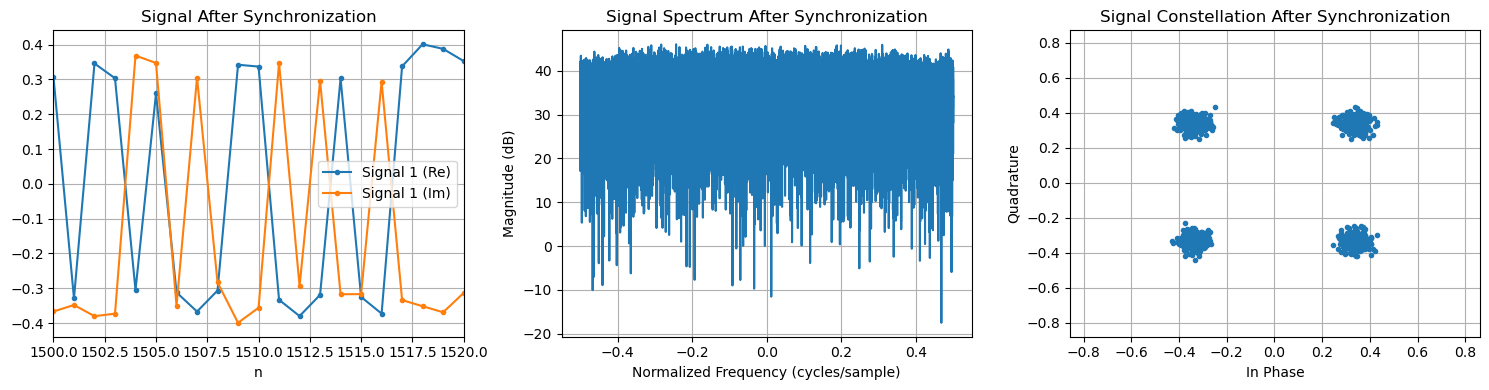

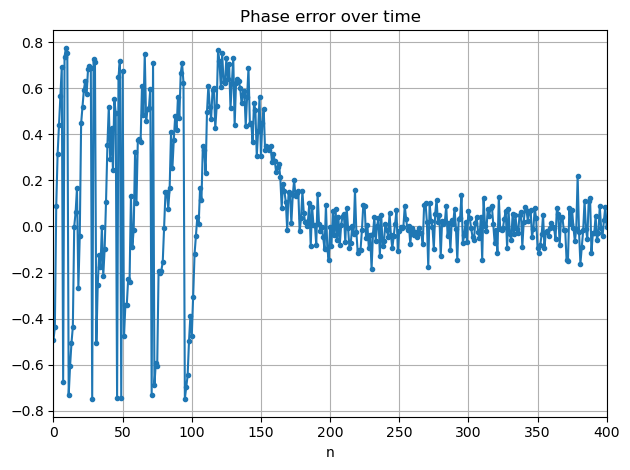

In [47]:
# 2nd Order Costas Loop
loop_bw = 1/20
sym_rot = np.empty_like(symbols_sampled, dtype=np.complex64)
costas = pu.carrier_recovery.CostasLoopQPSK(loop_bw)
costas.process(symbols_sampled, sym_rot)
symbols = np.array([sym_rot[i]*(i % SPS == 0) for i in np.arange(sym_rot.size)], dtype=sym_rot.dtype)


# Visualize after carrier recovery
fig, ax = vz.visualize(
    sym_rot, 
    plots=('time', 'frequency', 'constellation'), 
    plot_kwargs={
        'time': {'title': 'Signal After Synchronization', 'xlim': [1500, 1520]}, 
        'frequency': {'title': 'Signal Spectrum After Synchronization'},
        'constellation': {'title': 'Signal Constellation After Synchronization', 'xlim': [1500, 2500]}
    }
);

vz.plot_signal(costas.error_history, title='Phase error over time', xlim=[0, 400])
plt.tight_layout()
plt.show()

### Differential QPSK Demodulation

In [48]:
# Make optimum decision for AWGN channel
sym_rx = pu.modulation.optimum_decider_qpsk(sym_rot)
sym_rx = pu.coding.diff_decode_psk_symbols(sym_rx)
bits_rx = pu.modulation.demodulate_qpsk(sym_rx)

### BER Analysis

In [49]:
ber = pu.metrics.compute_er(bits_tx, bits_rx)[0]
print(f"BER: {ber}")

# print(bits_tx[1000:1015])
# print(bits_rx[1000:1015])
# locs = []
# for i in range(len(bits_tx)):
#     if bits_tx[i] != bits_rx[i]:
#         locs.append(i)
# print(locs)

BER: 0.00033
